## Big Data Assignement 4

Importing modules and defining Haversine formula to calculate the distance

In [31]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import lead
from pyspark.sql.functions import col, radians, cos, sin, sqrt, lag, atan2, lead, sum as sum_, length, unix_timestamp

def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

Initialising Spark session, renaming the columns and converitng the date to timestamp format

In [32]:
spark = SparkSession.builder.getOrCreate()

df = spark.read.csv("aisdk-2024-05-04.csv", header=True)

df = df.withColumnRenamed('# Timestamp', 'timestamp')
df = df.withColumn('timestamp', F.to_timestamp(F.col('timestamp'),
                                                                 'dd/MM/yyyy HH:mm:ss'))
df = df.withColumnRenamed('Latitude', 'lat')
df = df.withColumnRenamed('Longitude', 'long')

reduced_df = df.select("timestamp", "MMSI", "lat", "long", "IMO")

Filtering data according to [Spire Maritime documentation](https://documentation.spire.com/ais-fundamentals/ais-data-sources/terrestrial-ais/):

- Remove position data with unavailable coordinates (91 / 181).
- Filter out messages with invalid MMSI numbers. (Ships should report 9-digit MMSIs. Base stations should report 7-digit MMSIs.)
- Filter out messages with IMO numbers more than 7 digits. Note 7 digit IMO numbers still returned even when not matching the IMO checksum calculation.  

And dropping duplicates by 'MMSI', 'timestamp', 'latitude', 'longitude'

In [33]:
filtered_df = reduced_df.filter(
    ((length(col("MMSI")) == 9) | (length(col("MMSI")) == 7)) &
    (col("lat") != 91) & (col("long") != 181) &
    (col("lat") >= -90) & (col("lat") <= 90) &
    (col("long") >= -180) & (col("long") <= 180)
)

if "IMO" in filtered_df.columns:
    filtered_df = filtered_df.filter(length(col("IMO")) <= 7)

filtered_df = filtered_df.dropDuplicates(['MMSI', 'timestamp', 'lat', 'long'])

print(f"Number of records before cleaning: {reduced_df.count()}")
print(f"Number of records after cleaning: {filtered_df.count()}")

Number of records before cleaning: 19175663
Number of records after cleaning: 11896458


Defining a window specification to group data by 'MMSI' and order by 'timestamp'.  
Adding columns to the DataFrame for the next latitude and longitude.  
Calculating the distance in meters between consecutive coordinates using the Haversine formula, handling null values with zero.

In [34]:
windowSpec = Window.partitionBy("MMSI").orderBy("timestamp")

filtered_df = filtered_df.withColumn("next_latitude", lead(col("lat")).over(windowSpec))
filtered_df = filtered_df.withColumn("next_longitude", lead(col("long")).over(windowSpec))
filtered_df = filtered_df.withColumn("distance", F.coalesce(haversine(col("long"), col("lat"),
                                         col("next_longitude"), col("next_latitude")) * 1000, F.lit(0))) 

Calculating time differences in seconds between consecutive points.  
Calculating speeds in meters per second.  
Defining a maximum speed threshold in meters per second and filtering data based on that (maximum speed was chosen based on the maximum speed of the fastest vessen on Earth HSC Francisco (58.1 knots)) 

In [35]:
filtered_df = filtered_df.withColumn("prev_timestamp", lag("timestamp").over(windowSpec))
filtered_df = filtered_df.withColumn("time_diff_seconds", (unix_timestamp("timestamp") - unix_timestamp("prev_timestamp")))

filtered_df = filtered_df.withColumn("speed_mps", col("distance") / (col("time_diff_seconds") + F.lit(0.001)))

speed_threshold_mps = 58.1 * 0.51444 #(1 knot ≈ 0.51444 m/s)
filtered_df = filtered_df.filter(col("speed_mps") < speed_threshold_mps)

Finding the vessel with the longest distance traveled by summing total distance travelled.

In [37]:
total_distance_df = filtered_df.groupBy("MMSI").agg(sum_("distance").alias("total_distance"))

# Find the vessel with the longest distance traveled
longest_route = total_distance_df.orderBy(col("total_distance").desc()).first()

if longest_route:
    print(f"The vessel with MMSI {longest_route['MMSI']} traveled the longest distance of {round(longest_route['total_distance'])} meters.")
else:
    print("No valid data available after applying the speed threshold.")

The vessel with MMSI 219133000 traveled the longest distance of 757824 meters.


Based on the information online vessel 219133000  (VUOKSI MAERSK) travelled between Bremerhaven, Germany and Klaipeda, Lithuania between 2024-05-03 14:08 and 2024-05-05 17:25 on an average speed of 17.4 knots.  
The result of 757824 m = 757.8 km = 409 nm.  
Given the average speed of 17.4 knots, the vessel on 4th of May should have travelled an average of 17.4 x 24 = 417.6 nm which is similar to the result obtained.   
  
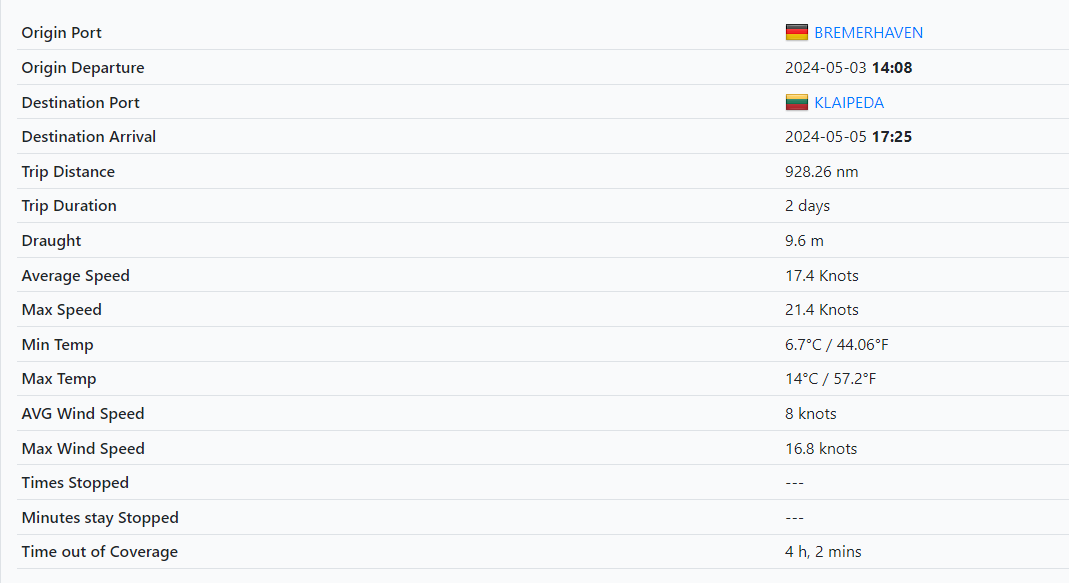